## 分析A/B测试结果

By **Batu Mengkai**

## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介

该数据集是某公司电子商务网站运行的A/B测试结果，包含294478条信息，每条信息有5个变量（如下表）。通过对该电子商务网站运行的A/B测试结果进行分析，来帮助公司弄清楚他们是否应该使用新的页面，还是保留旧页面，或延长测试时间，之后再做出决定。

|字段|描述|
|-:|:-|
|user_id|用户ID|
|timestamp|时间戳|
|group|组，分实验组和对照组|
|landing_page|用户分配到的页面，分新页面和旧页面|
|converted|是否转化，0代表未转化，1代表转化|

<a id='probability'></a>
### I - 概率

导入相关库

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 导入 `ab_data.csv` 数据，并将其存储在 `df` 中。 

a. 导入数据集，并在这里查看前几行：

In [2]:
df = pd.read_csv('ab-data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. 查看数据集中的行数。

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. 数据集中独立用户的数量。

In [4]:
df['user_id'].nunique()

290584

d. 用户转化的比例。

In [5]:
df['converted'].mean()

0.11965919355605512

e.  `new_page` 与 `treatment` 不一致的次数。

In [6]:
new_treatment_counts = ((df['landing_page']=='new_page')&(df['group']=='treatment')).sum()
old_control_counts = ((df['landing_page']=='old_page')&(df['group']=='control')).sum()
df.shape[0]- new_treatment_counts- old_control_counts

3893


f. 查看是否有任何行存在缺失值

In [7]:
df.isnull().sum().sum()

0

- 数据集中的行数为294478个。
- 数据集中独立用户的数量是290584个。
- 用户转化的比例是0.12
- new_page 与 treatment 不一致的次数是3893个
- 不存在缺失值

`2.` 对于 **treatment** 不与 **new_page** 一致的行或 **control** 不与 **old_page** 一致的行，我们不能确定该行是否真正接收到了新的或旧的页面。**决定删除这些行**。  

a. 现在创建一个符合测试规格要求的新数据集，即数据集的**treatment** 与 **new_page** 一致或 **control** 与 **old_page** 一致。将新 dataframe 存储在 **df2** 中。

In [8]:
df2 = df[((df['landing_page']=='new_page')&(df['group']=='treatment')) | ((df['landing_page']=='old_page')&(df['group']=='control'))]

In [9]:
# 复查是否所有不一致的行被删除，结果应该是0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 使用 **df2** 再次查看数据集。

a.  查看**df2** 中有多少唯一的 **user_id**

In [10]:
#查看df2中有多少行
df2.shape[0]

290585

In [11]:
#查看df2有多少唯一的user_id
df2['user_id'].nunique() 

290584

b.  **df2** 中有一个重复的 **user_id** 。查看这个重复的user_id

In [12]:
df2['user_id'].value_counts().idxmax()

773192

c. 这个重复的  **user_id** 的行信息是什么？

In [13]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. 删除 **一个** 含有重复的 **user_id** 的行， 但需要确保 dataframe 为 **df2**。

In [14]:
df2 = df2.drop(labels = 1899, axis =0)

In [15]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` 使用 **df2** 来了解数据集的转化率。

a. 不管它们收到什么页面，单个用户的转化率是多少？


In [16]:
#数据集整体的转化率
(df2['converted']==1).mean()

0.11959708724499628

c. 假定一个用户处于 `treatment` 组中，他的转化率是多少？


In [17]:
#假定一个用户处于treatment组中，他的转化率是多少？
df2[df2['group']=='treatment']['converted'].mean()

0.11880806551510564

In [18]:
#假定一个用户处于 control组中，他的转化率是多少？
df2[df2['group']=='control']['converted'].mean()

0.1203863045004612

d. 一个用户收到新页面的概率是多少？


In [19]:
(df2['landing_page']=='new_page').mean()

0.5000619442226688

e. 
- 在对照组`control`，用户转化率是0.120
- 在实验组`treatment`，用户转发率是0.118

根据以上的结果，我们不能认为有证据表明旧页面可以带来更多的转化，这个样本是总体中一部分，并不能代表总体的参数，因为没有排除这个样本是偶然性的可能。

<a id='ab_test'></a>
### II - A/B 测试

难点思考：一个页面被认为比另一页页面的效果好得多的时候你就要停止检验吗？还是需要在一定时间内持续发生？你需要将检验运行多长时间来决定哪个页面比另一个页面更好？

`1.` 现在根据提供的所有数据做出决定。

**思考逻辑：**
1. 如果我想证明新的页面效果更好，那么我只要否证`旧的页面效果更好`这个假设就行
2. 否证方式是：在旧的页面效果更好这个假设为真的情况下，观察到小概率事件的概率是否低于显著水平。


- 旧页面的转化率为 **$p_{old}$** 
- 新页面的转化率为 **$p_{new}$** 

**基于以上逻辑，零假设和备择假设为：**

 **零假设** $H_{0}$:  $p_{new}$ - $p_{old}$ <=0
 
 **备择假设** $H_{1}$:  $p_{new}$ - $p_{old}$ > 0

`2.` 在零假设中，$p_{new}$ - $p_{old}$ =0，代表了备择假设不成立情况下最坏情况，如果$p_{new}$ - $p_{old}$ =0成立，那么$p_{new}$ - $p_{old}$ < 0肯定也是成立的。所以我们只需证明假设$p_{new}$ - $p_{old}$ =0是否成立。<br><br>

- 在零假设为真情况下，实验组$n_{new}$和对照组$n_{old}$样本规模一样，那么$p_{new}$ 和 $p_{old}$ 都具有等于总体真 **转化** 成功率。<br><br>

- 假定在零假设中，不管是新页面还是旧页面， ，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，假设它们都等于**ab_data.csv** 中的 **转化** 率<br><br>

- 每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。  <br><br>

- 执行两次页面之间 **转化** 差异的抽样分布，计算零假设中10000次迭代计算的估计值。  <br><br>


a. 在零假设中，$p_{new}$ 的 **convert rate（转化率）** 是:


In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. 在零假设中， $p_{old}$  的 **convert rate（转化率）** 是: <br><br>

In [21]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c.  新页面样本规模$n_{new}$ 是:

In [22]:
n_new = df2[df2['landing_page']=='new_page']['user_id'].count()
n_new

145310

d.  旧页面样本规模$n_{old}$?是：

In [23]:
n_old = df2[df2['landing_page']=='old_page']['user_id'].count()
n_old

145274

e. 在零假设中，使用新页面转化率 $p_{new}$ 来模拟 $n_{new}$ 次交易，并将这些模拟的转化结果1's 与 0's 存储在 **new_page_converted** 中，得到新页面转化的数据**new_page_converted**。

In [24]:
new_page_converted = np.random.choice([1,0], size = n_new, p = [p_new, 1-p_new])

f. 在零假设中，使用旧页面转化率 $p_{old}$ 来模拟 $n_{old}$ 次交易，并将这些模拟的转化结果1's 与 0's 存储在 **old_page_converted** 中，得到旧页面转化的数据**old_page_converted**。

In [25]:
old_page_converted = np.random.choice([1,0], size = n_old, p= [p_old, 1-p_old])

g. 用模拟获得的转化结果的数据来计算新旧页面转化率差：

In [26]:
new_page_converted.mean() - old_page_converted.mean()

3.231253412526447e-05

h. 使用**a. 到 g.** 中的计算方法来模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 **p_diffs** 中。<br><br>

**p_diffs** 是零假设为真情况下，新旧页面转化率差的可能值

In [27]:
p_diffs = []
for _ in range(10000):
    p = df2['converted'].mean()
    new_page_converted = np.random.choice([1,0],size = n_new, p = [p, 1-p])
    old_page_converted = np.random.choice([1,0],size = n_old, p= [p, 1-p])
    diff = new_page_converted.mean()- old_page_converted.mean()
    p_diffs.append(diff)

i. 绘制一个 **p_diffs** 直方图。

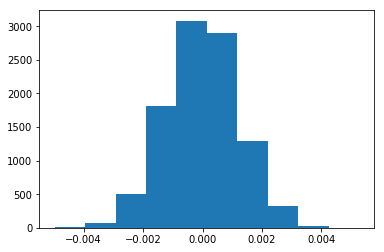

In [28]:
plt.hist(p_diffs);

j.  在零假设为真情况下，模拟的新旧页面转化率在**p_diffs**列表的数值中，有多大比例大于手头样本**ab_data.csv** 中观察到的实际差值？

In [29]:
#实际样本中新旧页面转化率差值
diff = df2[df['landing_page']=='new_page']['converted'].mean()- df2[df['landing_page']=='old_page']['converted'].mean()
diff

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


-0.0015782389853555567

In [30]:
#计算模拟值中大于手头样本中新旧页面转化率的比例
p_diffs = np.array(p_diffs)
p_val = (p_diffs > diff).mean()
p_val

0.9049

k. 在**j.**中计算出来的结果的解释。

科学研究中，这个值是p值，就是在零假设为真的情况下，能观察到当前样本以及比它更极端情况的概率<br><br>
p_val大于显著值5%，说明这个样本在零假设为真情况下不是小概率事件，有可能来自我们零假设，这样我们无法拒绝零假设，这时我们可以有证据证明，我们新页面相比旧页面没有提高转化率。

l. 使用statsmodels包中的一个内置程序 （built-in）来实现类似的结果。

尽管使用内置程序可能更易于编写代码，但上面的内容是对正确思考统计显著性至关重要的思想的一个预排。填写下面的内容来计算每个页面的转化次数，以及每个页面的访问人数。使用 `n_old` 与 `n_new` 分别引证与旧页面和新页面关联的行数。

In [31]:
import statsmodels.api as sm

convert_old = df2.loc[df['landing_page']=='old_page','converted'].sum()#旧页面中转化成功的次数
convert_new = df2.loc[df['landing_page']=='new_page','converted'].sum()#新页面中转化成功的次数
n_old = n_old#旧页面的样本大小
n_new = n_new#新页面的样本大小

m. 现在使用 `stats.proportions_ztest` 来计算检验统计量与 p-值。[这里](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 是使用内置程序的介绍链接。

In [32]:
count= [convert_new, convert_old]
nobs = [n_new, n_old]
z_score, p_value = sm.stats.proportions_ztest(count, nobs, value=None, alternative='larger', prop_var=False)
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

n. **对`k.`的结果的解释：**

- 从上面计算可以看出，p_value是0.905，我们无法拒绝零假设，我们样本来自零假设的可能性很大。**结论**是新页面相对旧页面，没有提高转化率。
- 这个计算的P-value与j.与k.计算的0.903几乎相等，是一致的。

<a id='regression'></a>
### III - 使用回归分析法

`1.` A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我们应该执行逻辑回归，因为结果是二分类


b. 目标是使用 **statsmodels** 来拟合你在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。



但是，首先，你需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [33]:
df2['intercept'] = 1#创建截距列

In [34]:
df2[['control','ab_page']] = pd.get_dummies(df['group'])#将group列转化为虚拟变量
df2 = df2.drop(labels = 'control', axis = 1)#删除control列

In [35]:
df2.head()#打印查看准备的数据

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0



c. 使用 **statsmodels** 导入你的回归模型。 实例化该模型，并使用你在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [36]:
import statsmodels.api as sm

In [37]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)#消除因为python3和库不兼容的bug
log_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])#因变量为converted，自变量是intercept,ab_page
results = log_mod.fit()#拟合模型

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. 下方提供模型摘要

In [38]:
results.summary()#打印模型拟合结果

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Oct 2018   Pseudo R-squ.:               8.077e-06
Time:                        12:46:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [39]:
np.exp(-0.0150)

0.9851119396030626

e. **解读结果**

1. ab_page关联的P-value是0.190，大于0.05，无法拒绝零假设，所以是否是新页面跟是否转化无关。
2. 逻辑回归模型中，零假设是:是否是新页面（ab_page）与是否转化(converted)**无关系**，备择假设是：是否是新页面（ab_page）与是否转化(converted)**有关系**
3. Part II中，零假设是： 新页面转化率小于等于等于旧页面转化率；备择假设是：新页面转化率大于就业面转化率。
4. 两个假设出发角度不同，导致计算出的P_value是不同的。

f. 现在考虑其他可能影响用户是否发生转化的因素：为什么考虑将其他因素添加到回归模型中是一个不错的主意？在回归模型中添加附加项有什么弊端吗：

- 添加其他因素，能够发现此因素是否与影响用户转化有关，能提高我们逻辑回归模型的拟合度。
- 增加解释模拟结果难度，有可能出现多重共线性，从而影响模型的可靠性。

g. 现在导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 [这里](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) 是链接表格的文档。 

这个国家项对转化有影响吗？

In [40]:
df3 = pd.read_csv('countries.csv')
df2 = df2.merge(df3, how = 'left',on='user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [41]:
df2['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [42]:
df2[['CA','UK','US']] = pd.get_dummies(df2['country'])
df2 =df2.drop(labels = 'UK', axis = 1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1


In [43]:
log_mod2 = sm.Logit(df2['converted'], df2[['intercept','ab_page','CA','US']])
results2 = log_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 24 Oct 2018   Pseudo R-squ.:               2.323e-05
Time:                        12:46:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

**添加国家项的结论：** 与CA相关联的p_value是0.074，与US相关联的p_value是0.457，都大于0.05， 说明CA和US地区对影响页面转化没有显著帮助。 

h. 虽然现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

提供你的摘要结果，以及根据结果得出的结论。

**页面与国家/地区的相互作用，逻辑回归中添加交叉项**
```
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
```

In [44]:
df2['new_CA'] = df2['ab_page']*df2['CA']
df2['new_US'] = df2['ab_page']*df2['US']

In [45]:
log_mod3 = sm.Logit(df2['converted'],df2[['intercept','ab_page','CA','US','new_CA','new_US']])
lr_results = log_mod3.fit()
lr_results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 24 Oct 2018   Pseudo R-squ.:               3.482e-05
Time:                        12:46:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
US             0.0057      0.019      0.306      0.760      -0.031       0.043
new_CA        -0.0783      0.057     -1.378      0.168      -0.190       0.033
new_US        -0.0314      0.027     -1.181      0.238      -0.084       0.021
==============================================================================
"""

从回归结果来看，p_value都大于0.05，可以说明新添加的交叉项对影响转换没有显著的帮助。

<a id='conclusions'></a>
## 总结

从这个新旧页面的AB测试样本结果来看，**新页面相对旧页面不能提高转化率**